In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import time
current_milli_time = lambda: int(round(time.time() * 1000))

In [2]:
# normalize [0, 1] -> [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data/from_pytorch_download', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, 
                                          shuffle=True, num_workers=2)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# show image sample

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

4 torch.Size([4, 3, 32, 32])


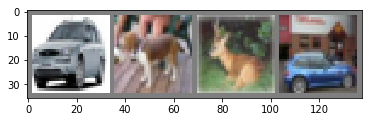

  car   dog  deer   car


In [5]:
data_iter = iter(train_loader)

images, labels = data_iter.next()
print(len(images), images.size())

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [6]:
# build ConvNet
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.pool = nn.MaxPool2d(2, 2) # maxpooling use for every conv1D
        self.conv1 = nn.Conv2d(3, 6, 5) # 5x5 mask, 6 channels, input channel RGB
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fn1 = nn.Linear(5 * 5 * 16, 120)
        self.fn2 = nn.Linear(120, 84)
        self.fn3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fn1(x))
        x = F.relu(self.fn2(x))
        x = self.fn3(x)
        return x

In [7]:
net = Net()

In [8]:
# loss and optimizer
import torch.optim as optim
criteion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [9]:
for epoch in range(2):
    
    running_loss = 0.0
    start_time = current_milli_time()
    for i, data in enumerate(train_loader, 0):
        # inputs
        inputs, labels = data
        optimizer.zero_grad()
        
        # forward
        outputs = net(inputs)
        # backward
        loss = criteion(outputs, labels)
        loss.backward() # parameter's grad is maden.
        # optimize
        optimizer.step()
        
        # statictics
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f \t time: %ds' % (
                epoch + 1, 
                i + 1, 
                running_loss / 2000, 
                (current_milli_time() - start_time) / 1000.))
            running_loss = 0.0
            start_time = current_milli_time()
            
print('Finished Training')

[1,  2000] loss: 2.230 	 time: 10s
[1,  4000] loss: 1.872 	 time: 6s
[1,  6000] loss: 1.718 	 time: 6s
[1,  8000] loss: 1.629 	 time: 6s
[1, 10000] loss: 1.514 	 time: 6s
[1, 12000] loss: 1.506 	 time: 7s
[2,  2000] loss: 1.413 	 time: 10s
[2,  4000] loss: 1.385 	 time: 6s
[2,  6000] loss: 1.388 	 time: 7s
[2,  8000] loss: 1.332 	 time: 6s
[2, 10000] loss: 1.327 	 time: 6s
[2, 12000] loss: 1.303 	 time: 6s
Finished Training


In [10]:
# evaluation
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


In [11]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1



for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 65 %
Accuracy of   car : 73 %
Accuracy of  bird : 39 %
Accuracy of   cat : 26 %
Accuracy of  deer : 64 %
Accuracy of   dog : 42 %
Accuracy of  frog : 66 %
Accuracy of horse : 58 %
Accuracy of  ship : 55 %
Accuracy of truck : 48 %


In [12]:
# GPU

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
print(device)

cuda:0


In [14]:
net = Net()
net.to(device)

Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fn1): Linear(in_features=400, out_features=120, bias=True)
  (fn2): Linear(in_features=120, out_features=84, bias=True)
  (fn3): Linear(in_features=84, out_features=10, bias=True)
)

In [15]:
import torch.optim as optim
criteion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [16]:
for epoch in range(2):
    
    running_loss = 0.0
    start_time = current_milli_time()
    device_time = 0
    for i, data in enumerate(train_loader, 0):
        # inputs
        inputs, labels = data
        
        start_of_to_device = current_milli_time()
        inputs, labels = inputs.to(device), labels.to(device)
        device_time += current_milli_time() - start_of_to_device
        
        optimizer.zero_grad()
        
        # forward
        outputs = net(inputs)
        # backward
        loss = criteion(outputs, labels)
        loss.backward() # parameter's grad is maden.
        # optimize
        optimizer.step()
        
        # statictics
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f \t time: %ds device: %dms' % (
                epoch + 1, 
                i + 1, 
                running_loss / 2000, 
                (current_milli_time() - start_time) / 1000.,
                device_time)
            )
                
            running_loss = 0.0
            start_time = current_milli_time()
            device_time = 0
            
print('Finished Training')

[1,  2000] loss: 2.175 	 time: 20s device: 739ms
[1,  4000] loss: 1.848 	 time: 13s device: 630ms
[1,  6000] loss: 1.673 	 time: 13s device: 661ms
[1,  8000] loss: 1.555 	 time: 13s device: 684ms
[1, 10000] loss: 1.499 	 time: 13s device: 590ms
[1, 12000] loss: 1.435 	 time: 13s device: 653ms
[2,  2000] loss: 1.371 	 time: 18s device: 671ms
[2,  4000] loss: 1.364 	 time: 13s device: 627ms
[2,  6000] loss: 1.329 	 time: 13s device: 642ms
[2,  8000] loss: 1.321 	 time: 13s device: 684ms
[2, 10000] loss: 1.285 	 time: 13s device: 667ms
[2, 12000] loss: 1.274 	 time: 13s device: 646ms
Finished Training
